<a href="https://colab.research.google.com/github/ljy9969/Study/blob/master/AWS(0422)_TFRecord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

filenames = tf.io.gfile.glob('./data/kaggle_cat_dog/train/*.jpg')

print(len(filenames))  # 25000

25000


In [ ]:
import warnings
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import io

warnings.filterwarnings(action='ignore')

filenames = tf.io.gfile.glob('./data/kaggle_cat_dog/train/*.jpg')

print(filenames[0], filenames[1])




./data/kaggle_cat_dog/train/cat.12406.jpg ./data/kaggle_cat_dog/train/cat.3199.jpg


In [ ]:
############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# tf.Example 객체 생성
def to_example(filename):
    image_string = tf.io.read_file(filename)    
    
    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'
    # cat이면 False(0), dog이면 True(1)
       
    shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# TFRecord 파일 생성
tfrecords_path = './TFRecord_Write_Read_Example.tfrecords'

with tf.io.TFRecordWriter(tfrecords_path) as writer:
    try:
        # print(to_example(filenames[0]).SerializeToString())
        tf_example = to_example(filenames[0])
        writer.write(tf_example.SerializeToString())
        tf_example = to_example(filenames[1])
        writer.write(tf_example.SerializeToString())        
    except:
        print(f'fail: {filename}')

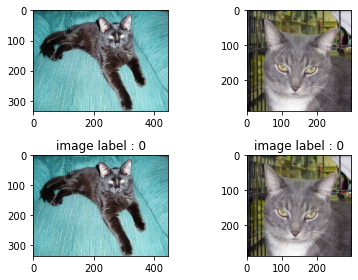

In [ ]:
# TFRecord 파일로 부터 data 복구

raw_image_dataset = tf.data.TFRecordDataset(tfrecords_path)

# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channel': tf.io.FixedLenFeature([], tf.int64),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
    'image/image_raw': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string)
}


def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

fig = plt.figure()

axes = []

for i in range(4):
    axes.append(fig.add_subplot(2,2,i+1))
    
    
k=2

for image_features in parsed_image_dataset:
    
    image_raw = image_features['image/image_raw'].numpy()  # byte array
    image_label = image_features['image/label'].numpy()  # byte array
      
    decoded = np.array(Image.open(io.BytesIO(image_raw)))  # ndarray   

    axes[k].imshow(decoded)
    axes[k].set_title('image label : {}'.format(image_label))
    k+=1
    
# filenames[0], filenames[1] 파일의 shape과 이미지를 먼저 살펴보자.

    
img = Image.open(filenames[0])
pixel = np.array(img)
axes[0].imshow(pixel)

img = Image.open(filenames[1])
pixel = np.array(img)
axes[1].imshow(pixel)


# print('image의 shape : {}'.format(pixel.shape))
    
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.notebook import tqdm
from PIL import Image
import io


############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


############ DataFrame 생성 ############        
    
src = './data/kaggle_cat_dog/train/'

df = pd.DataFrame(os.listdir(src),
                  columns=['filename'])

df['label'] = ~df['filename'].str.contains('cat')

df = df.astype({'label': 'int'})

df['filename']  = df['filename'].map(lambda x : src + x)

display(df)

############ TFRecord 생성 함수 정의 ############        
        
def to_tfrecords(id_list, label_list, tfrecords_name):
    # id_list : 이미지파일명을 가지고 있는 list
    # label_list : 이미지파일의 label을 가지고 있는 list
    # tfrecords_name : tfrecord의 이름(train,validation 구별을 위해필요)
    
    print("Converting 시작 (" + os.path.join(tfrecords_name + '.tfrecords') + ' 파일생성)')
    # GZIP으로 압축한 TFRecord 생성하기 위한 option
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
        
    with tf.io.TFRecordWriter(path=os.path.join(tfrecords_name + '.tfrecords'), 
                              options=options) as writer:
        
        # tqdm은 반복문의 진행상황을 progressbar를 보여주는 모듈
        # tqdm 파라미터

        # iterable : 반복자 객체
        # desc : 진행바 앞에 텍스트 출력
        # total : int, 전체 반복량
        # leave : bool, default로 True. (진행상태 잔상이 남음)
        # ncols : 진행바 컬럼길이. width 값으로 pixel 단위로 보임.
        # mininterval, maxinterval : 업데이트 주기. 
        #                            기본은 mininterval=0.1 sec, maxinterval=10 sec
        # miniters : Minimum progress display update interval, in iterations.
        # ascii : True로 하면 '#'문자로 진행바가 표시됨.
        # initial : 진행 시작값. 기본은 0
        # bar_format : str

        # tqdm method
        # clear() : 삭제
        # refresh() : 강제 갱신
        
        for id_, label_ in tqdm(zip(id_list, label_list), 
                                total=len(id_list), 
                                position=0, 
                                leave=True):
            image_path = id_
            
            # TFRecord를 생성하는 시점에 resize를 할수도 있고 TFRecord를 읽어서 DataSet을 만들때
            # resize를 할 수 도 있다. 
            # resize 된 이미지를 저장할 경우 처리에 주의해야 한다. 
            # 잘못하는 경우 이미지 데이터가 깨져서 저장될 수 있음.
            # 일반적으로 원본을 저장하고 사용할 때 resize해서 사용하는것이 일반적임.
            
            # 원본 이미지를 resize하지 않고 TFRecord로 저장.
            _binary_image = tf.io.read_file(image_path)
            
            # Example 객체 생성
            # 파이썬의 문자열은 모두 unicode. unicode 문자열을 byte배열로 바꾸는 함수가 encode()
            # 각 type에 맞게 Feature 객체 생성 후 dict 생성. 
            # 이 dict를 이용해 Feauture 객체 생성 후 Example 객체 생성.
            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'label': _int64_feature(label_)                
            }))

            # 만들어진 Example 객체를 binary string으로 변환한 후 파일에 저장
            writer.write(string_set.SerializeToString())    
            

############ 데이터 분리 및 TFRecord 생성 함수 호출 ############        

train_ids, val_ids, train_labels, val_labels = \
    train_test_split(df['filename'], 
                     df['label'], 
                     test_size=0.2, 
                     random_state=40, 
                     shuffle=True)


to_tfrecords(train_ids, train_labels, './cat_dog_train')
to_tfrecords(val_ids, val_labels, './cat_dog_valid')


,filename,label
0,./data/kaggle_cat_dog/train/cat.12406.jpg,0
1,./data/kaggle_cat_dog/train/cat.3199.jpg,0
2,./data/kaggle_cat_dog/train/cat.3941.jpg,0
3,./data/kaggle_cat_dog/train/dog.11143.jpg,1
4,./data/kaggle_cat_dog/train/dog.12152.jpg,1
...,...,...
24995,./data/kaggle_cat_dog/train/dog.9069.jpg,1
24996,./data/kaggle_cat_dog/train/cat.11297.jpg,0
24997,./data/kaggle_cat_dog/train/dog.3848.jpg,1
24998,./data/kaggle_cat_dog/train/dog.2575.jpg,1


Converting 시작 (./cat_dog_train.tfrecords 파일생성)


  0%|          | 0/20000 [00:00<?, ?it/s]

2022-04-22 14:14:42.196352: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-22 14:14:42.196612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 14:14:42.202047: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Converting 시작 (./cat_dog_valid.tfrecords 파일생성)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
### TFRecord 파일 여러개로 생성하기 ###

import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings(action='ignore')

############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def to_example(filename):
    # TFRecord를 생성하는 시점에 resize를 할수도 있고 TFRecord를 읽어서 DataSet을 만들때
    # resize를 할 수 도 있다. 
    # resize 된 이미지를 저장할 경우 처리에 주의해야 한다. 
    # 잘못하는 경우 이미지 데이터가 깨져서 저장될 수 있음.
    # 일반적으로 원본을 저장하고 사용할 때 resize해서 사용하는것이 일반적임.
            
    # 원본 이미지를 resize하지 않고 TFRecord로 저장.
    image_string = tf.io.read_file(filename)    
    
    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'
    # cat이면 False(0), dog이면 True(1)
    
    shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())        
    }
    
    # Example 객체 생성
    # 파이썬의 문자열은 모두 unicode. unicode 문자열을 byte배열로 바꾸는 함수가 encode()
    # 각 type에 맞게 Feature 객체 생성 후 dict 생성. 
    # 이 dict를 이용해 Feauture 객체 생성 후 Example 객체 생성.
    return tf.train.Example(features=tf.train.Features(feature=feature))


def chunkify(filename_list, n):
    size = len(filename_list) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(filename_list[start:start + size])
        start += size
    results.append(filename_list[start:])
    return results


# tqdm은 반복문의 진행상황을 progressbar를 보여주는 모듈

# tqdm 파라미터
# iterable : 반복자 객체
# desc : 진행바 앞에 텍스트 출력
# total : int, 전체 반복량
# leave : bool, default로 True. (진행상태 잔상이 남음)
# ncols : 진행바 컬럼길이. width 값으로 pixel 단위로 보임.
# mininterval, maxinterval : 업데이트 주기. 
#                            기본은 mininterval=0.1 sec, maxinterval=10 sec
# miniters : Minimum progress display update interval, in iterations.
# ascii : True로 하면 '#'문자로 진행바가 표시됨.
# initial : 진행 시작값. 기본은 0
# bar_format : str

# tqdm method
# clear() : 삭제
# refresh() : 강제 갱신
        
def build_tfrecords(total_shards_num, split, filenames):
    chunks = chunkify(filenames, total_shards_num)
    failed = 0
    for i, chunk in tqdm(enumerate(chunks),
                         total=len(chunks),
                         position=0,
                         leave=True):        
        tfrecords_path = './tfrecords/{}_{}_of_{}.tfrecords'.format(split,
                                                                    str(i + 1).zfill(4),
                                                                    str(total_shards_num).zfill(4))
        # GZIP으로 압축한 TFRecord 생성하기 위한 option
        # options = tf.io.TFRecordOptions(compression_type='GZIP')
        
        # with tf.io.TFRecordWriter(tfrecords_path, options=options) as writer:
        with tf.io.TFRecordWriter(tfrecords_path) as writer:
            for filename in chunk:
                try:
                    tf_example = to_example(filename)
                    
                    # 만들어진 Example 객체를 binary string으로 변환한 후 파일에 저장
                    writer.write(tf_example.SerializeToString())
                except:
                    print(f'fail: {filename}')
    
    
os.makedirs('tfrecords', exist_ok=True)
filenames = tf.io.gfile.glob('./data/kaggle_cat_dog/train/*.jpg')

train_data, valid_data = train_test_split(filenames, train_size=0.8)

build_tfrecords(100, 'train', train_data)
build_tfrecords(100, 'valid', valid_data)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import os
import tensorflow as tf

# 학습에 필요한 DataSet 준비(여러개의 tfrecord 처리)

# train, validation TFRecord 폴더 경로(여러개의 tfrecord 처리)
# 폴더를 나누고 파일을 복사하는건 수동으로 처리
train_tfrecord_path = './tfrecords/train'
valid_tfrecord_path = './tfrecords/valid'

train_tfrecord_list = tf.io.gfile.glob(train_tfrecord_path + '/*.tfrecords')
valid_tfrecord_list = tf.io.gfile.glob(valid_tfrecord_path + '/*.tfrecords')

# 읽어들인 TFRecord를 다음의 형태(dict)로 변환하는 함수
# <ParallelMapDataset shapes: {id: (), image_raw: (), label: ()}, 
#                     types: {id: tf.string, image_raw: tf.string, label: tf.int64}>
def _parse_image_function(example_proto):
    # TFRecord를 읽어서 데이터를 복원하기 위한 자료구조.
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/channel': tf.io.FixedLenFeature([], tf.int64),
        'image/label': tf.io.FixedLenFeature([], tf.int64),
        'image/image_raw': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example_proto, 
                                      image_feature_description)

# 위에서 얻은 ParallelMapDataset를 다음의 형태(shape)로 변환하는 함수
# <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
def map_func(target_record):      
    img = target_record['image/image_raw']
    label = target_record['image/label']
    img = tf.image.decode_jpeg(img, channels=3)    
    return img, label


# 전처리(normalization & resize) 함수
# 이미지 데이터 normalization
# 우리예제는 TFRecord 생성 시 원본 size로 저장했기 때문에 image resize를 해야함.
def image_preprocess_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image, 
                                   (IMAGE_SIZE,IMAGE_SIZE),
                                   antialias=False)   
    return result_image, label


# 만약 multinomial classification이면 one_hot처리도 필요함.
def image_postprocess_func(image, label):
#    onehot_label = tf.one_hot(label, depth=1049)    # binary인 경우 one_hot 사용안함.    
    return image, label


def make_dataset(tfrecords_path, is_train):
    
    dataset = tf.data.TFRecordDataset(tfrecords_path)

    dataset = dataset.map(_parse_image_function,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(map_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(image_preprocess_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(image_postprocess_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

###################################################


import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


############### Parameter
NUM_OF_TFRECORDS = 5 # 종류별 TFRecord의 개수
BUFFER_SIZE = 16     # 데이터 shuffle을 위한 buffer size
BATCH_SIZE = 8       # 배치 사이즈. 한번에 가져오는 이미지 데이터 개수 
NUM_CLASS = 2        # class의 개수. binary인 경우는 필요없으며 categorical인 경우 설정
IMAGE_SIZE = 150       

############### Model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_layer')  

## Pretrained Network
pretrained_model = VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                         input_tensor=input_layer)

pretrained_model.trainable = False

x = pretrained_model.output

x = Flatten()(x)
x = Dense(256,
          activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=x)


# EarlyStopping & Checkpoint & Learning Rate
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_acc", 
                        patience = 3, 
                        factor = 0.5, 
                        min_lr=1e-7,
                        verbose=1)

model_filename = './checkpoint/cat-dog-{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.hdf5'

checkpointer = ModelCheckpoint(
    filepath=model_filename, 
    verbose=1, 
    save_freq='epoch', 
    save_best_only=True, 
    monitor='val_acc')

es = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

# LearningRateScheduler 이용
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])



# 데이터 세팅 후 학습(여러개(100개)의 tfrecord를 이용한 학습)
for i in tqdm(range(NUM_OF_TFRECORDS),
              total=NUM_OF_TFRECORDS,
              position=0,
              leave=True):
    tfrecord_train_file = train_tfrecord_list[i]
    tfrecord_valid_file = valid_tfrecord_list[i]
    
    dataset = make_dataset(tfrecord_train_file, True)
    valid_dataset = make_dataset(tfrecord_valid_file, False)
    
    model.fit(dataset,
              epochs=20,
              validation_data=valid_dataset,
#               callbacks = [checkpointer, es, learning_rate_reduction],
              callbacks = [checkpointer],
              verbose=0)       

print('############### 기본학습 종료 ###############')    

# 여기까지가 기본학습 처리입니다.

# Pretrained Network 위에 새로운 Network을 추가합니다.
# Base Network을 동결합니다.
# 새로 추가한 Network을 학습합니다.


# 아래의 작업이 추가로 필요합니다.
# Base Network에서 일부 Layer의 동결을 해제합니다.
# 동결을 해제한 층과 새로 추가한 층을 함께 학습합니다.

pretrained_model.trainable = True

for layer in pretrained_model.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:    
        layer.trainable = False

## learning rate를 줄이는게 일반적(미세조절)        

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
    
    
    
## 재학습 진행
print('########### 재학습 진행 ###########')

for i in tqdm(range(NUM_OF_TFRECORDS),
              total=NUM_OF_TFRECORDS,
              position=0,
              leave=True):

    tfrecord_train_file = train_tfrecord_list[i]
    tfrecord_valid_file = valid_tfrecord_list[i]
    
    dataset = make_dataset(tfrecord_train_file, True)
    valid_dataset = make_dataset(tfrecord_valid_file, False)
    
    model.fit(dataset,
              epochs=20,
              validation_data=valid_dataset,
#               callbacks = [checkpointer, es, learning_rate_reduction],
              callbacks = [checkpointer],
              verbose=0)            

# 결과그래프(loss, accuracy)를 그리는것은 한번 고민해보시기 바랍니다.!!

# 프로그램 수행환경 
# Server : AWS EC2 2.4.1
#          1 GPU(Tesla T4), 16GB GPU Memory
# CUDA : 11.0.4, cuDNN : 8
# Tensorflow-gpu : 2.4.1
 
# 최종 저장된 모델

# 5개의 TFRecord로 학습한 경우
# Epoch 00016: val_acc improved from 0.95300 to 0.95400, 
# saving model to ./checkpoint/cat-dog-000016-0.954000-1.000000.hdf5

# 1개의 TFRecord로 학습한 경우
# Epoch 00015: val_acc improved from 0.95140 to 0.95420, 
# saving model to ./checkpoint/cat-dog-000015-0.954200-0.995150.hdf5